In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab"

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])

In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input dataset for lgbm
train_dset = lgb.Dataset(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
    free_raw_data=True
)
valid_dset = lgb.Dataset(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
    free_raw_data=True
)

In [7]:
import gc
gc.collect()

44

***
## Bayesian Optimization

In [8]:
default_params = {
    'boosting': 'dart',
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 128,
    'max_bin':511,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e8),
    'feature_pre_filter' : False,
}

In [9]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [10]:
def objective(trial):    
    sampled_params = dict(
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.1, 0.5, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.8, 1.0, 0.05),
        lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-3, 1e1),
        lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-3, 1e1),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1000, 3000, 100),
        path_smooth = trial.suggest_float("path_smooth", 0., 100.),
        drop_rate = trial.suggest_discrete_uniform("drop_rate", 0.05, 0.2, 0.01),
        max_drop = trial.suggest_int("max_drop", 10, 100, 10),
        skip_drop = trial.suggest_discrete_uniform("skip_drop", 0.25, 0.75, 0.05),
    )
    model_params = {**default_params, **sampled_params}
    
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=trial.suggest_int("num_iterations", 800, 2000, 100),
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(features_valid)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
do_optimize = False

study = optuna.create_study(
    study_name="lgbm-dart",
    direction='maximize',
    storage='sqlite:///lgbm-dart.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=43200, # 12-hrs
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-03-02 17:45:14,061] Using an existing study with name 'lgbm-dart' instead of creating a new one.


In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_drop_rate,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_drop,params_min_data_in_leaf,params_num_iterations,params_path_smooth,params_skip_drop,state
35,35,0.135104,2022-03-01 21:23:47.687516,2022-03-01 23:09:22.753601,0 days 01:45:35.066085,0.90,0.09,0.35,1.112742,0.001745,90,2200,1900,7.961233,0.55,COMPLETE
32,32,0.135010,2022-03-01 18:41:40.341100,2022-03-01 19:34:21.395818,0 days 00:52:41.054718,0.90,0.06,0.20,3.233071,0.002490,60,2400,1700,38.807106,0.60,COMPLETE
37,37,0.134554,2022-03-02 03:51:17.790463,2022-03-02 05:38:43.493053,0 days 01:47:25.702590,0.85,0.09,0.35,2.521982,0.001811,90,2200,1900,6.732627,0.55,COMPLETE
42,42,0.134193,2022-03-02 13:06:03.856813,2022-03-02 14:56:57.150020,0 days 01:50:53.293207,0.85,0.07,0.40,0.508152,0.006243,90,2400,2000,8.273905,0.55,COMPLETE
41,41,0.134125,2022-03-02 11:38:11.217367,2022-03-02 13:06:03.736833,0 days 01:27:52.519466,0.85,0.07,0.40,2.650939,0.002779,90,2400,1700,9.092071,0.55,COMPLETE
36,36,0.134080,2022-03-02 02:02:21.810575,2022-03-02 03:51:17.665945,0 days 01:48:55.855370,0.85,0.09,0.35,2.767042,0.002009,90,2200,1900,8.968306,0.55,COMPLETE
31,31,0.134075,2022-03-01 17:57:32.906389,2022-03-01 18:41:40.232690,0 days 00:44:07.326301,0.90,0.05,0.20,2.421860,0.002928,70,2500,1600,20.091225,0.65,COMPLETE
6,6,0.134067,2022-03-01 03:15:27.787455,2022-03-01 03:53:01.613463,0 days 00:37:33.826008,1.00,0.19,0.15,0.103959,0.025984,60,1700,1500,24.278093,0.70,COMPLETE
40,40,0.134054,2022-03-02 09:40:46.264955,2022-03-02 11:38:11.103274,0 days 01:57:24.838319,0.85,0.09,0.35,5.003803,0.001947,100,2200,1900,4.894997,0.55,COMPLETE
1,1,0.133776,2022-02-28 23:54:33.703370,2022-03-01 00:05:32.294606,0 days 00:10:58.591236,0.95,0.09,0.15,1.121625,0.002035,20,2500,1000,15.076167,0.70,COMPLETE


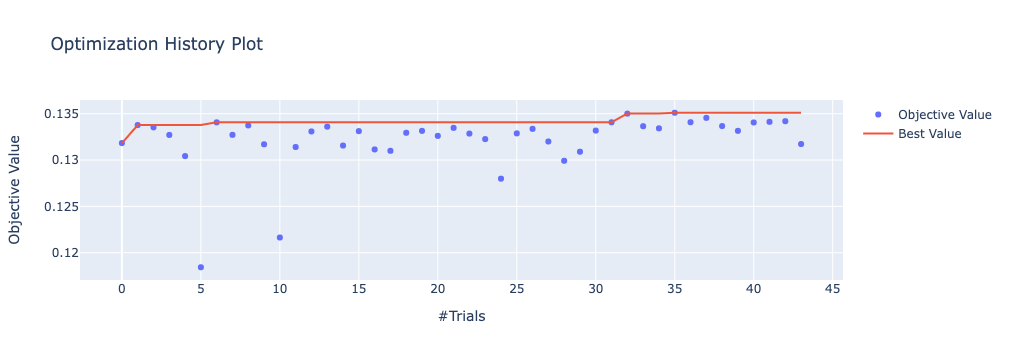

In [13]:
plot_optimization_history(study)

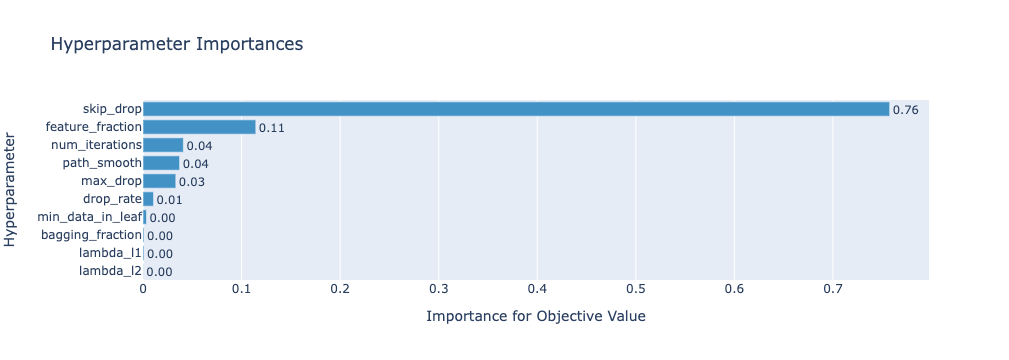

In [14]:
plot_param_importances(study)

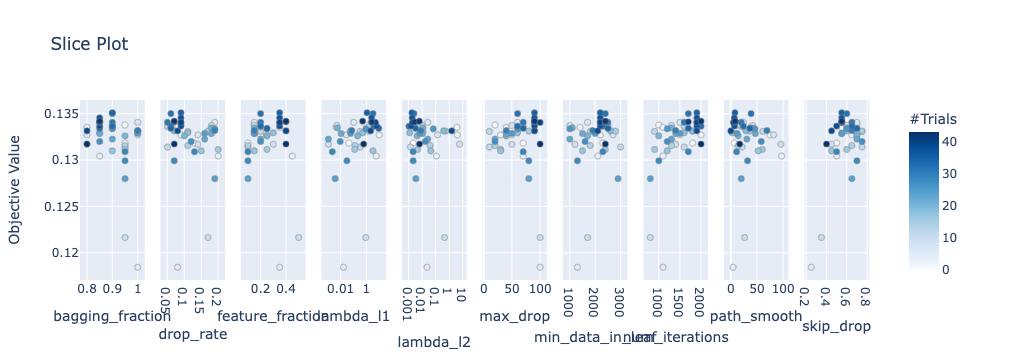

In [15]:
plot_slice(study)

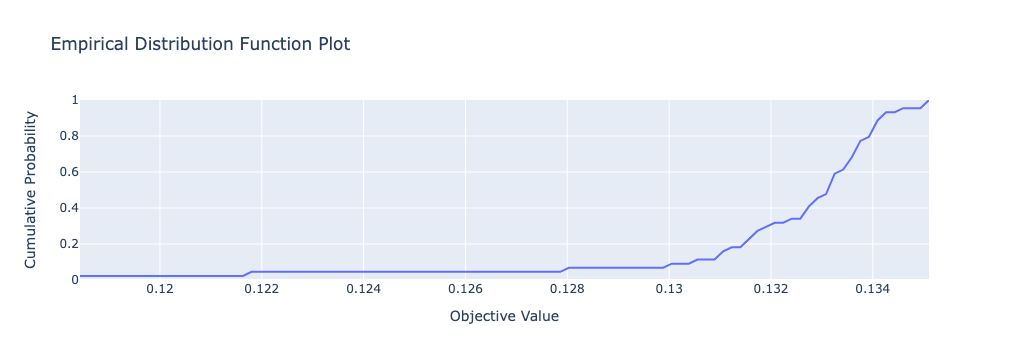

In [16]:
plot_edf(study)

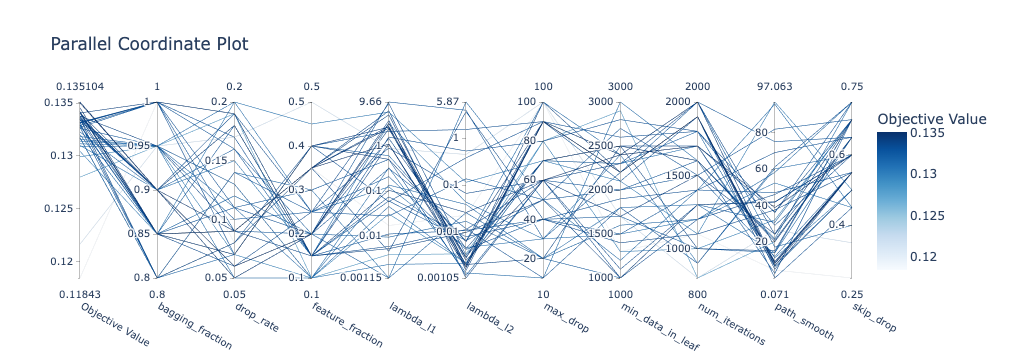

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params = {**default_params, **best_params}
best_params

{'boosting': 'dart',
 'objective': 'mse',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'num_leaves': 128,
 'max_bin': 511,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 19,
 'verbosity': -1,
 'first_metric_only': False,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': False,
 'bagging_fraction': 0.9,
 'drop_rate': 0.09,
 'feature_fraction': 0.35,
 'lambda_l1': 1.1127423904283282,
 'lambda_l2': 0.0017447397071228327,
 'max_drop': 90,
 'min_data_in_leaf': 2200,
 'num_iterations': 1900,
 'path_smooth': 7.961233039539337,
 'skip_drop': 0.55}

***